In [1]:
import matplotlib as mpl
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os

# Init NuScenes. Requires the dataset to be stored on disk.
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap

matplotlib.rcParams['figure.figsize'] = (24, 18)
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams.update({'font.size': 20})

TRAIN_SIZE = 9800
TRAIN_TIME = 6
BATCH_SIZE = 32
BUFFER_SIZE = 500

In [2]:
total_ped_matrix = np.load("details/total_ped_matrix.npy")

with open("details/ped_dataset.pkl", "rb") as f:
    ped_dataset = pickle.load(f)
    
with open('details/scene_info.pkl', 'rb') as handle:
    scene_info = pickle.load(handle)

In [3]:
nusc = NuScenes(version='v1.0-trainval', \
                dataroot='../../../../data/', \
                verbose=False)

In [4]:
so_map = NuScenesMap(dataroot='../../../../data/', \
                       map_name='singapore-onenorth')
bs_map = NuScenesMap(dataroot='../../../../data/', \
                       map_name='boston-seaport')
sh_map = NuScenesMap(dataroot='../../../../data/', \
                       map_name='singapore-hollandvillage')
sq_map = NuScenesMap(dataroot='../../../../data/', \
                       map_name='singapore-queenstown')

# dict mapping map name to map file
map_files = {'singapore-onenorth': so_map,
             'boston-seaport': bs_map,
             'singapore-hollandvillage': sh_map,
             'singapore-queenstown': sq_map}

In [5]:
# train_test split
x_train = total_ped_matrix[:TRAIN_SIZE, :TRAIN_TIME, :]
y_train = total_ped_matrix[:TRAIN_SIZE, TRAIN_TIME:, :2]
y_train = y_train.reshape(TRAIN_SIZE, 20)

x_test = total_ped_matrix[TRAIN_SIZE:, :TRAIN_TIME, :]
y_test = total_ped_matrix[TRAIN_SIZE:, TRAIN_TIME:, :2]

In [7]:
# predict based on previous position and velocity
def cv_model(idx):
    pos_t0 = np.array(ped_dataset[idx]['translation'])[5, :2]
    vel_t0 = np.diff(np.array(ped_dataset[idx]['translation'])[:, :2], axis=0)[5]

    dt = 0.5
    cv_predictions = []

    cur_pos = pos_t0 

    for _ in range(len(ped_dataset[idx]['translation']) - TRAIN_TIME):
        new_pos = cur_pos + dt*vel_t0
        cv_predictions.append(new_pos)
        cur_pos = new_pos
        
    return cv_predictions

# loss calculation for test prediction
def rmse_error(l1, l2):
    loss = []
    
    if len(np.array(l1).shape) < 2:
        return ((l1[0] - l2[0])**2 + (l1[1] - l2[1])**2)**0.5, None, None
    for p1, p2 in zip(l1, l2):
        loss.append(((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5)
    
    loss = np.array(loss)
    return np.mean(loss), loss.min(), loss.max() 

In [8]:
rmse_values = []
fde_valus = []
min_deviations = []
max_deviations = []

for test_idx in range(TRAIN_SIZE, len(ped_dataset)):
    test_data = np.reshape(total_ped_matrix[test_idx,:6,:]
                           , (1, 42))
    predictions = cv_model(test_idx)

#     n_scene = ped_dataset[test_idx]["scene_no"]
#     ego_poses = map_files[scene_info[str(n_scene)]["map_name"]].render_egoposes_on_fancy_map(
#                     nusc, scene_tokens=[nusc.scene[n_scene]['token']], verbose=False,
#                     render_egoposes=True, render_egoposes_range=False, 
#                     render_legend=False)

#     plt.scatter(*zip(*np.array(ped_dataset[test_idx]["translation"])[:6,:2]), c='k', s=5, zorder=2)
#     plt.scatter(*zip(*np.array(ped_dataset[test_idx]["translation"])[6:,:2]), c='b', s=5, zorder=3)
#     plt.scatter(*zip(*predictions), c='r', s=5, zorder=4)
#     plt.show()
    
    loss, min_dev, max_dev = rmse_error(predictions, 
                              np.array(ped_dataset[test_idx]["translation"])[6:,:2])
        
    final_loss, _, _ = rmse_error(predictions[-1], 
                            np.array(ped_dataset[test_idx]["translation"])[-1,:2])
    
    min_deviations.append(min_dev)
    max_deviations.append(max_dev)

    rmse_values.append(loss)
    fde_valus.append(final_loss)
    
print(f"RMSE Loss in m is {np.mean(np.array(rmse_values))}")
print(f"Loss of final position in m is {np.mean(np.array(final_loss))}")

RMSE Loss in m is 1.2827321921176151
Loss of final position in m is 0.5394450852484185


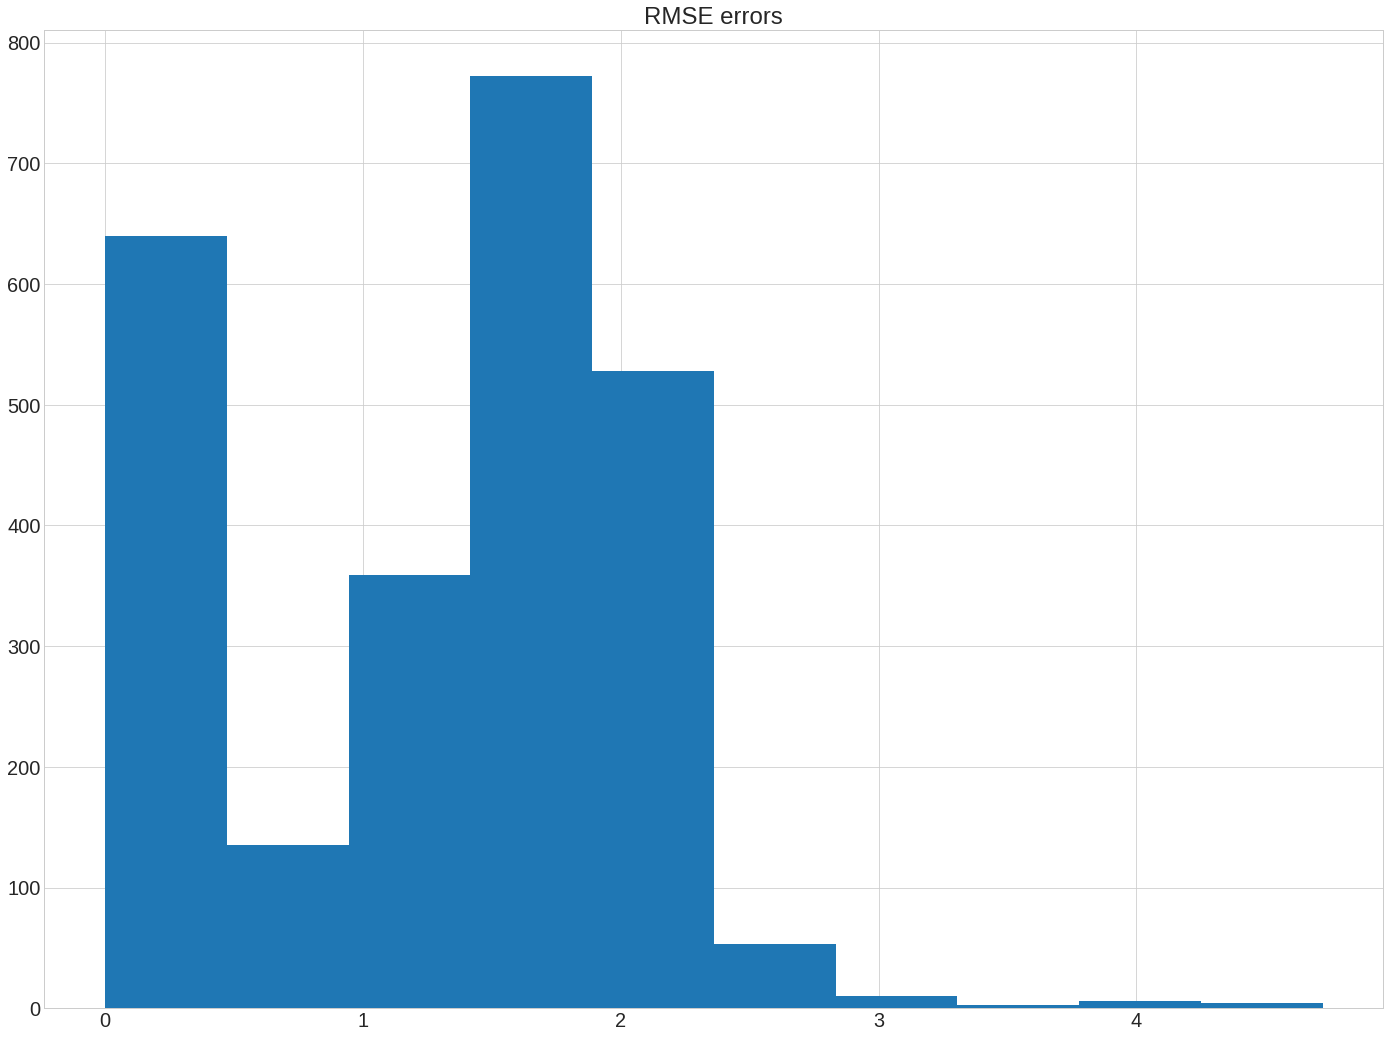

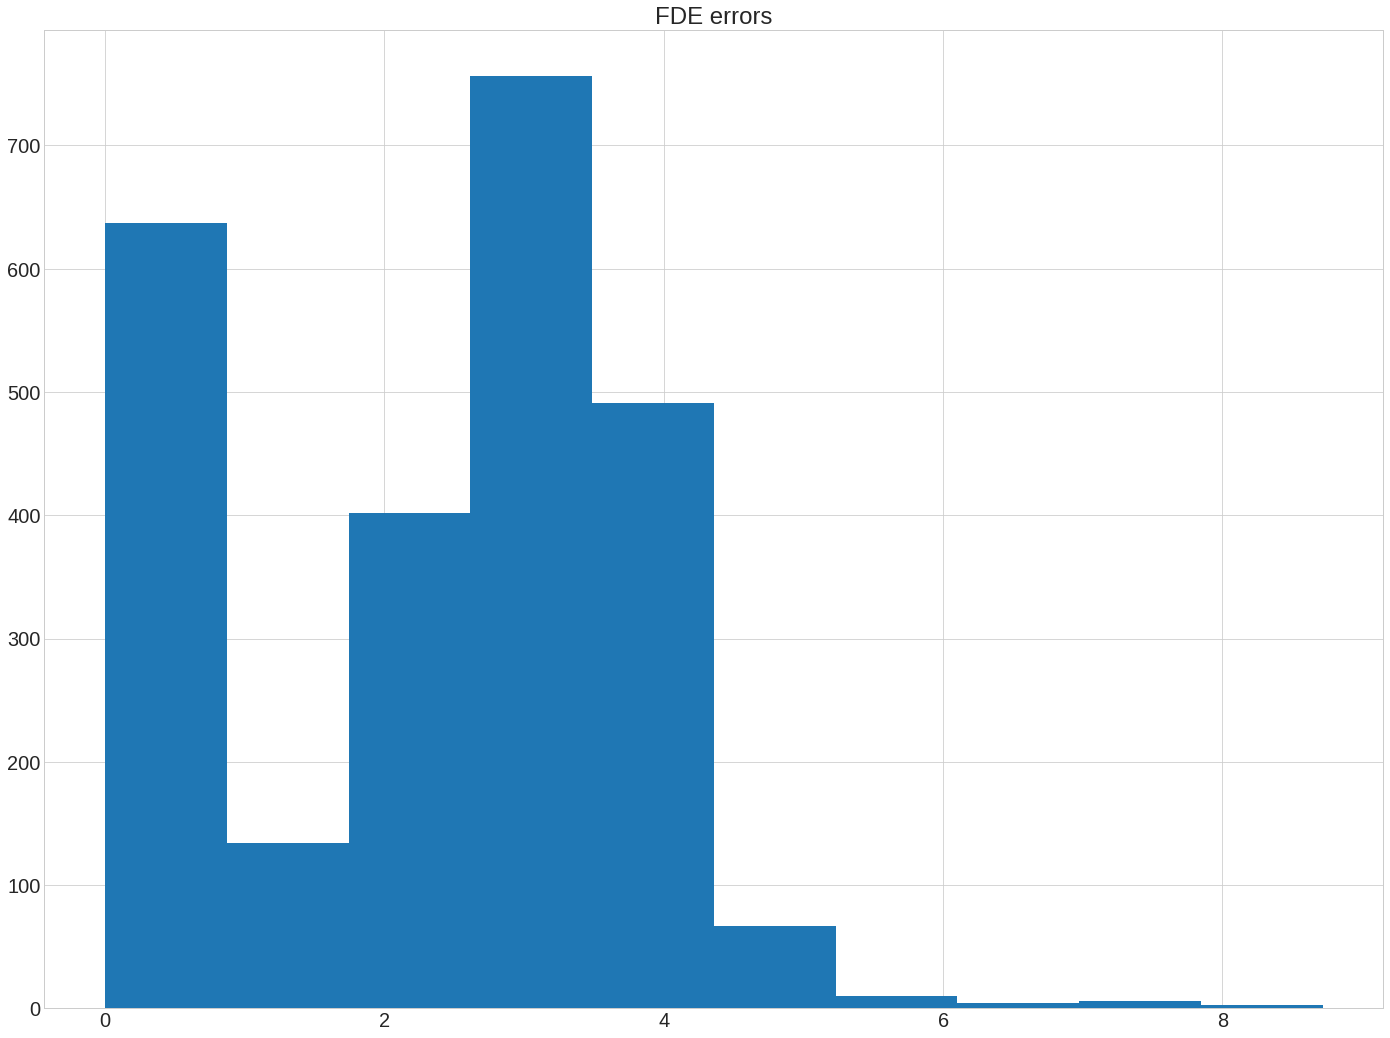

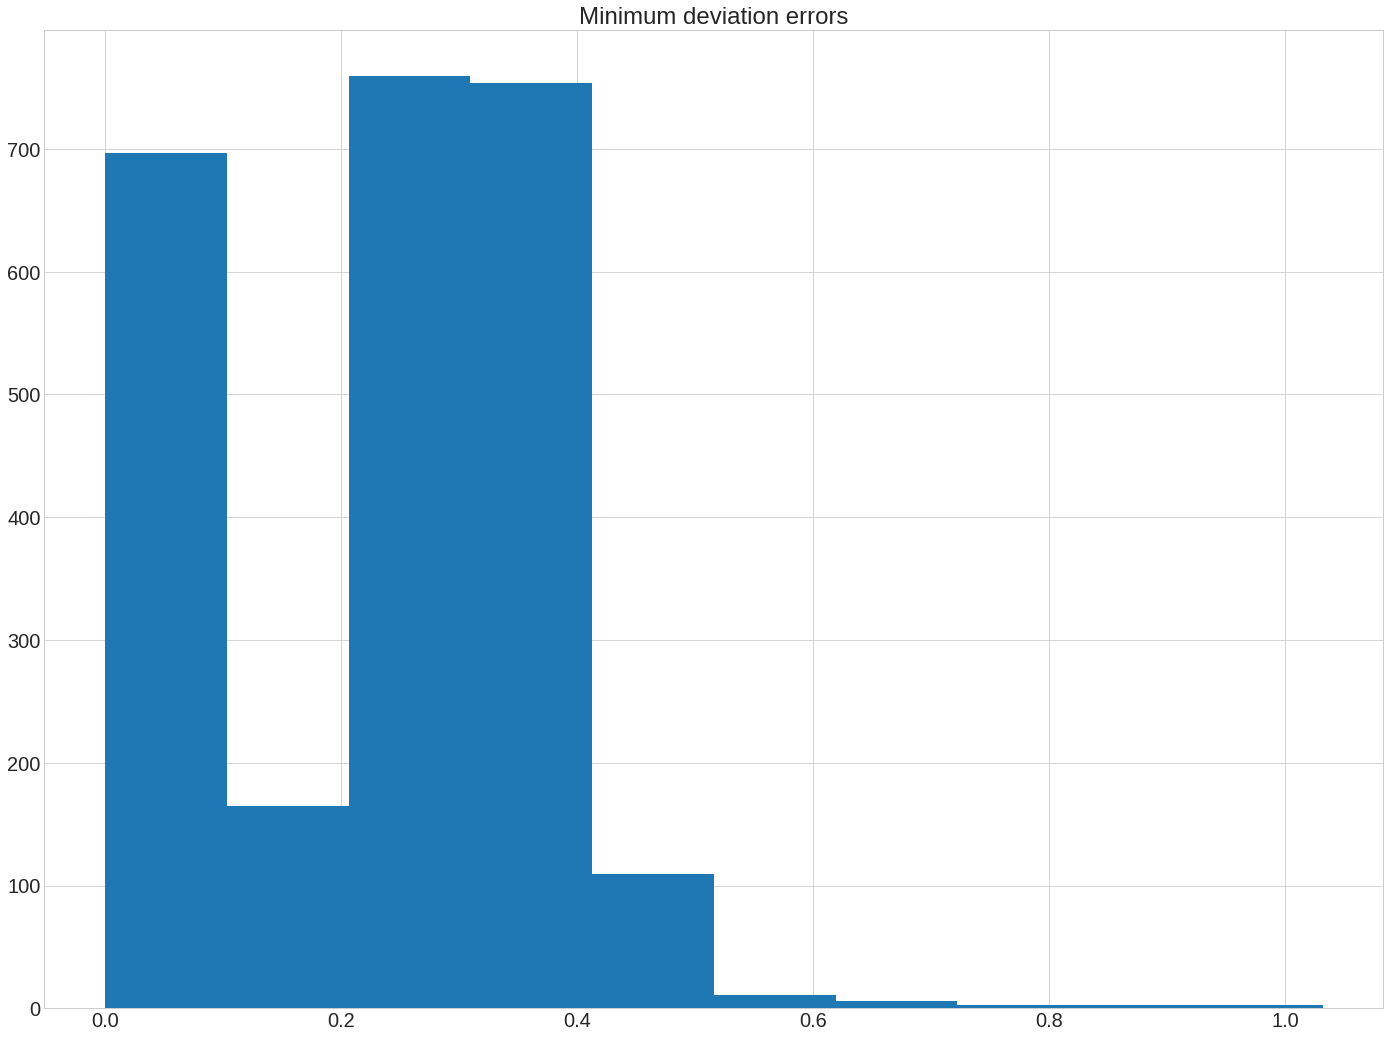

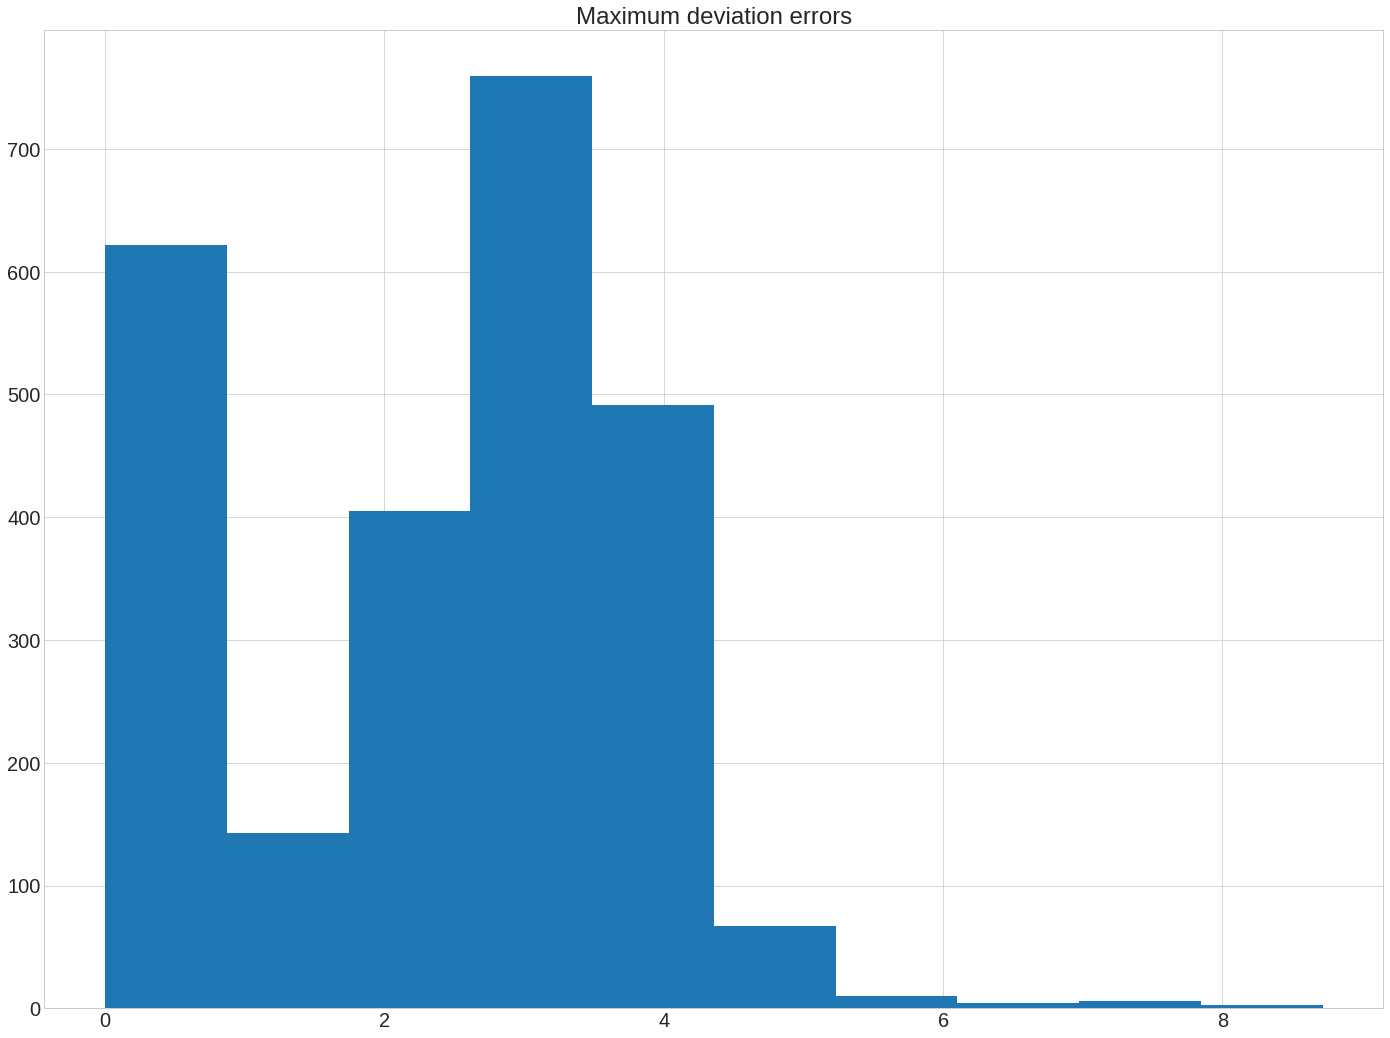

In [13]:
plt.hist(rmse_values)
plt.title("RMSE errors")
plt.show()

plt.hist(fde_valus)
plt.title("FDE errors")
plt.show()

plt.hist(min_deviations)
plt.title("Minimum deviation errors")
plt.show()

plt.hist(max_deviations)
plt.title("Maximum deviation errors")
plt.show()